# Parametric optimization -- inductor

In [90]:
# donner un pipfile pour la config

from shapeOptInductor import create_plots, update_plots, rot, gen_mesh2, Id  # noqa: F401
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt

## 1 - Geometry and meshing

In [91]:
airgap =  4.11e-3 * np.array([1, 1, 1, 1])
thickness = 1e-2

maxh = 2e-3
mesh = gen_mesh2(airgap, maxh)


XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})

Draw(1 * XiAir + 2 * XiCoil + 3 * XiCore, mesh, radius=0.02)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 2 - Computation of magnetic state

In [92]:
# Frequency
f = 5e4  # Hz
omega = 2 * np.pi * f

# Magnetic
mu0 = 4e-7 * np.pi
mur = 1000
mu_iron = mur * mu0
delta = 0.1
mu_coil = np.exp(-1j * delta) * mu0  #  AC losses in the copper from the imaginary part of the permeability

# Current
nb_turn = 200  # Number of turn in the coil
Is = 2  # Source current intensity
js = nb_turn / 2 * Is / (ngs.Integrate(XiCoil, mesh)) * XiCoil  # Source current density


def magWeakFormComplex(a, a_):
    bf = ngs.grad(a_) * 1 / mu_iron * ngs.grad(a) * ngs.dx("core")
    bf += ngs.grad(a_) * 1 / mu_coil * ngs.grad(a) * ngs.dx("coil")
    bf += ngs.grad(a_) * 1 / mu0 * ngs.grad(a) * ngs.dx("air")
    lf = a_ * js * ngs.dx("coil")
    return bf, lf


def solveStateComplex(mesh):
    fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
    a, a_ = fes.TnT()
    bf, f = magWeakFormComplex(a, a_)
    K, F = ngs.BilinearForm(fes), ngs.LinearForm(fes)
    K += bf
    F += f
    K.Assemble()
    F.Assemble()
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    gf.vec.data = Kinv * F.vec
    return gf, Kinv


a, Kinv = solveStateComplex(mesh)
Draw(ngs.Norm(a), mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [93]:
def Inductance(a, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return 4 * thickness / (Is**2) * ngs.Integrate(rel.real * ngs.Norm(ngs.grad(a)) ** 2, mesh)

def dInductance(a, p_, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return 2 * 4 * thickness / (Is**2) * ngs.InnerProduct(rel.real * ngs.grad(a), ngs.grad(p_)) * ngs.dx()

def Losses(a, mesh):
    rel = XiCoil / mu_coil
    return 4 * omega / 2 * thickness * ngs.Integrate(rel.imag * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def dLosses(a, p_, mesh):
    rel = XiCoil / mu_coil
    return 2 * 4 * omega / 2 * thickness * ngs.InnerProduct(rel.imag * ngs.grad(a), ngs.grad(p_)) * ngs.dx()


print(f" L = {Inductance(a,mesh) * 1e6 :.2f} µH")
print(f" P_AC = {Losses(a,mesh) :.2f} W")

 L = 1000.08 µH
 P_AC = 13.16 W


In [94]:
# optim parameters
L_target = 1e-3
l = 0
b = 1

def Constraint(a, mesh):
    return Inductance(a, mesh) - L_target


def CostFunction(a, mesh):
    const =  Constraint(a, mesh)
    return Losses(a, mesh) + l * const + 0.5 * b * const ** 2


# Adjoint

In [95]:
def solveAdjoint(a0, df, Kinv):
    """Solves the adjoint equation for a given df"""
    fes = a0.space
    p, p_ = fes.TnT()
    f = ngs.LinearForm(fes)
    f += -1 * df(a0, p_, fes.mesh)
    f.Assemble()
    gf = ngs.GridFunction(fes)
    gf.vec.data = Kinv.H * f.vec
    return gf


## Gradient

In [96]:
from shapeOptInductor import referenceVelocity

v11, v12, v21, v22 = referenceVelocity(mesh)


In [97]:
def SDLosses(a0, p0):
    """Shape derivative for the losses inside the coil"""
    mesh = a0.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex = True)
    X = FEScomplex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    coeff_losses = 4 * omega / 2 * thickness * (1 / mu_coil).imag
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(FEScomplex)
    dLOmega += coeff_losses * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx("coil")
    dLOmega += -js * XiCoil * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(FESReal)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ

def SDInductance(a0, p0):
    """Shape derivative for the inductance"""
    mesh = a0.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex = True)
    X = FEScomplex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix
    coeff_induc = 4 * thickness / (Is**2) * rel.real
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(FEScomplex)
    dLOmega += coeff_induc * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx
    dLOmega += -js * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(FESReal)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ

def shapeGrad(a0, p0, dJ):
    v11, v12, v21, v22 = referenceVelocity(a0.space.mesh)
    dJlf = dJ(a0, p0)
    FES = ngs.VectorH1(a0.space.mesh)
    dJ = ngs.GridFunction(FES)
    dJ.vec.FV().NumPy()[:] = np.real(dJlf.vec.FV().NumPy()[:])
    g11 = ngs.InnerProduct(dJ.vec, v11.vec)
    g12 = ngs.InnerProduct(dJ.vec, v12.vec)
    g21 = ngs.InnerProduct(dJ.vec, v21.vec)
    g22 = ngs.InnerProduct(dJ.vec, v22.vec)
    return g11, g12, g21, g22


In [98]:
# taylor tests

nTest = 0

H = np.logspace(-8,-3,10)
airgap = 4.11e-3 * np.array([1, 1, 1, 1])
maxh = 2e-3
mesh = gen_mesh2(airgap, maxh)
v11, v12, v21, v22 = referenceVelocity(mesh)

a0, Kinv = solveStateComplex(mesh)

if nTest == 0:
    f, df, SDf = Inductance, dInductance, SDInductance  
elif nTest == 1:
    f, df, SDf = Losses, dLosses, SDLosses
    
F0 = f(a0, mesh)
p0 = solveAdjoint(a0, df, Kinv)
dF = shapeGrad(a0, p0, SDf)
H = np.logspace(-8,-2,10)
Fh11, Fh12, Fh21, Fh22 = [], [], [], []

Def = ngs.GridFunction(ngs.VectorH1(mesh))

for h in H:
    ## g11
    Def.Set(v11 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh11.append(f(a, mesh))
    ## g12
    Def.Set(v12 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh12.append(f(a, mesh))
    ## g21
    Def.Set(v21 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh21.append(f(a, mesh))
    ## g22
    Def.Set(v22 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh22.append(f(a, mesh))


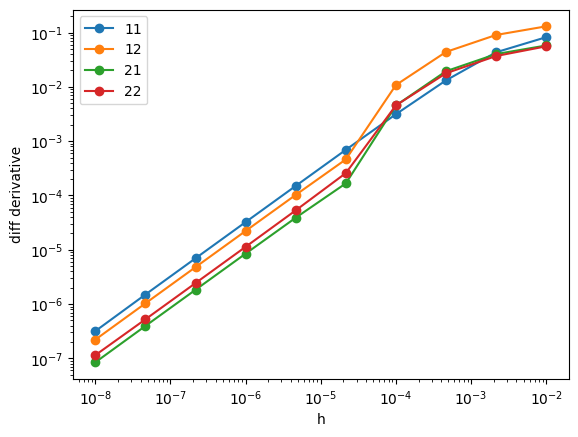

In [99]:
FD11 = (np.array(Fh11) - F0) / H
FD12 = (np.array(Fh12) - F0) / H
FD21 = (np.array(Fh21) - F0) / H
FD22 = (np.array(Fh22) - F0) / H


plt.loglog(H, np.abs(FD11- dF[0]), '-o', label = "11") ; plt.xlabel('h')
plt.loglog(H, np.abs(FD12- dF[1]), '-o', label = "12")
plt.loglog(H, np.abs(FD21- dF[2]), '-o', label = "21") ; plt.ylabel('diff derivative')
plt.loglog(H, np.abs(FD22- dF[3]), '-o', label = "22")
plt.legend()
plt.show()

In [100]:
# taylor tests (objective)

l = 3
b = 2

H = np.logspace(-8,-3,10)
airgap = 4.11e-3 * np.array([1, 1, 1, 1])
maxh = 2e-3
mesh = gen_mesh2(airgap, maxh)
v11, v12, v21, v22 = referenceVelocity(mesh)

a0, Kinv = solveStateComplex(mesh)
    
F0 = CostFunction(a0, mesh) # Losses(a, mesh) + l * Constraint(a, mesh) + 0.5 * b * Constraint(a, mesh) ** 2
pL = solveAdjoint(a0, dLosses, Kinv)
pI = solveAdjoint(a0, dInductance, Kinv)

dF = np.array(shapeGrad(a0, pL, SDLosses)) + l * np.array(shapeGrad(a0, pI, SDInductance)) + b * Constraint(a0, mesh) * np.array(shapeGrad(a0, pI, SDInductance))
H = np.logspace(-8,-2,10)
Fh11, Fh12, Fh21, Fh22 = [], [], [], []

Def = ngs.GridFunction(ngs.VectorH1(mesh))

for h in H:
    ## g11
    Def.Set(v11 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh11.append(CostFunction(a, mesh))
    ## g12
    Def.Set(v12 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh12.append(CostFunction(a, mesh))
    ## g21
    Def.Set(v21 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh21.append(CostFunction(a, mesh))
    ## g22
    Def.Set(v22 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh22.append(CostFunction(a, mesh))

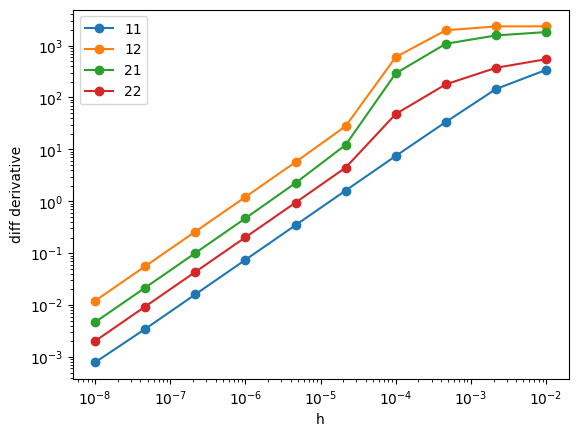

In [101]:
FD11 = (np.array(Fh11) - F0) / H
FD12 = (np.array(Fh12) - F0) / H
FD21 = (np.array(Fh21) - F0) / H
FD22 = (np.array(Fh22) - F0) / H


plt.loglog(H, np.abs(FD11- dF[0]), '-o', label = "11") ; plt.xlabel('h')
plt.loglog(H, np.abs(FD12- dF[1]), '-o', label = "12")
plt.loglog(H, np.abs(FD21- dF[2]), '-o', label = "21") ; plt.ylabel('diff derivative')
plt.loglog(H, np.abs(FD22- dF[3]), '-o', label = "22")
plt.legend()
plt.show()

In [102]:
# taylor tests (Constraint)

l = 3
b = 2

H = np.logspace(-8,-3,10)
airgap = 4.11e-3 * np.array([1, 1, 1, 1])
maxh = 2e-3
mesh = gen_mesh2(airgap, maxh)
v11, v12, v21, v22 = referenceVelocity(mesh)

a0, Kinv = solveStateComplex(mesh)
    
F0 = Constraint(a0, mesh) # Losses(a, mesh) + l * Constraint(a, mesh) + 0.5 * b * Constraint(a, mesh) ** 2
pI = solveAdjoint(a0, dInductance, Kinv)

dF = np.array(shapeGrad(a0, pI, SDInductance))
H = np.logspace(-8,-2,10)
Fh11, Fh12, Fh21, Fh22 = [], [], [], []

Def = ngs.GridFunction(ngs.VectorH1(mesh))

for h in H:
    ## g11
    Def.Set(v11 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh11.append(Constraint(a, mesh))
    ## g12
    Def.Set(v12 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh12.append(Constraint(a, mesh))
    ## g21
    Def.Set(v21 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh21.append(Constraint(a, mesh))
    ## g22
    Def.Set(v22 * h)
    mesh.SetDeformation(Def)
    a, _ = solveStateComplex(mesh)
    Fh22.append(Constraint(a, mesh))

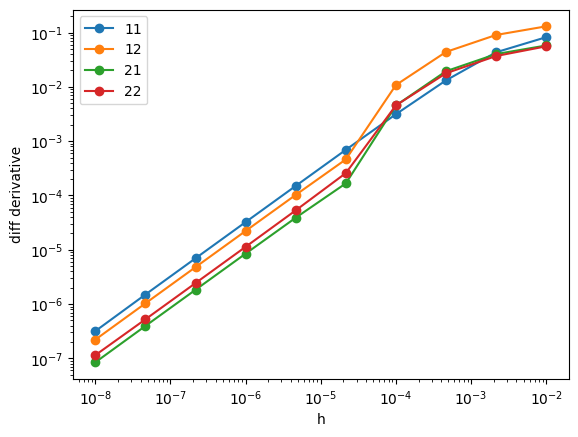

In [103]:
FD11 = (np.array(Fh11) - F0) / H
FD12 = (np.array(Fh12) - F0) / H
FD21 = (np.array(Fh21) - F0) / H
FD22 = (np.array(Fh22) - F0) / H


plt.loglog(H, np.abs(FD11- dF[0]), '-o', label = "11") ; plt.xlabel('h')
plt.loglog(H, np.abs(FD12- dF[1]), '-o', label = "12")
plt.loglog(H, np.abs(FD21- dF[2]), '-o', label = "21") ; plt.ylabel('diff derivative')
plt.loglog(H, np.abs(FD22- dF[3]), '-o', label = "22")
plt.legend()
plt.show()

## Optimization Loop

In [122]:
# augmented lagrangian

def innerMinimization(airgap, lam, beta, alpha, n_max = 50, alpha_min = 1e-5, scale = 1e4):
    n = 0
    airgapMin = 1e-4
    airgapMax = 1.49e-2
    mesh = gen_mesh2(airgap, maxh = maxh)
    a, Kinv = solveStateComplex(mesh)
    loss = Losses(a, mesh)
    ind = Inductance(a,mesh)
    objectiveHistory = [loss + lam * ( scale * (ind - L_target) ) + beta / 2 * (scale * (ind - L_target))**2]
    constraintHistory = [ind - L_target]
    airgapHistory = [airgap.copy()]
    inductanceHistory = [ind]
    lossesHistory = [loss]
    while ( n < n_max and alpha > alpha_min):
        mesh = gen_mesh2(airgap, maxh = maxh)
        # 1) Calcul de l'état physique :
        a, Kinv = solveStateComplex(mesh)

        # 2) Calcul de l'état adjoint :
        pInd = solveAdjoint(a, dInductance, Kinv)
        pLos = solveAdjoint(a, dLosses, Kinv)
        
        # 3) Calcul du gradient :
        gradient = np.array(shapeGrad(a, pLos, SDLosses)) 
        gradient += lam * scale * np.array(shapeGrad(a, pInd, SDInductance))
        gradient += beta * scale ** 2 * (Inductance(a, mesh) - L_target) * np.array(shapeGrad(a, pInd, SDInductance))

        # 4) Mise à jour :
        airgapTest = airgap -  alpha * gradient / np.linalg.norm(gradient)
        n += 1
        
        # 5) Projection :
        airgapTest[airgapTest < airgapMin] = airgapMin
        airgapTest[airgapTest > airgapMax] = airgapMax
        
        # 6) Contrôle du pas :
        meshTest = gen_mesh2(airgapTest, maxh = maxh)
        a_test, _ = solveStateComplex(meshTest)
        loss = Losses(a_test, mesh)
        ind = Inductance(a_test,mesh)
        objectiveHistory.append(loss + lam * scale * (ind - L_target) + beta / 2 * (scale * (ind - L_target))**2)
        constraintHistory.append(ind - L_target)
        inductanceHistory.append(ind)
        lossesHistory.append(loss)
        
        print(f'it n°{n} | f = {objectiveHistory[-1] :.5e} | L = {inductanceHistory[-1]:.5e} | P = {lossesHistory[-1]:.5e} | step = {alpha : .2e}')
        
        if objectiveHistory[-1] >= objectiveHistory[-2]:
            alpha = alpha/2
            objectiveHistory.pop(); constraintHistory.pop()
            inductanceHistory.pop(); lossesHistory.pop()
        elif objectiveHistory[-1] < objectiveHistory[-2]:
            alpha = alpha*1.2
            airgap = airgapTest
            airgapHistory.append(airgap)
    return airgap, alpha, objectiveHistory, constraintHistory, lossesHistory, inductanceHistory, airgapHistory

In [123]:
## Initialisation

lam = 0
scale = 1e3
beta = 500         # Coefficient de pénalisation (à faire varier)
alpha = 1e-3 / 2      # Pas initial
airgap =  4.11e-3 * np.array([1, 1, 1, 1])

alpha_min = 1e-7  # Pas minimal
N_max = 20      # Nombre d'itérations de l'algorithme d'optimisation
n_max = 20

ConstList = []
LagrList = []
lamList = [lam]
LossList = []
InductanceList = []
AirgapList = []
N = 0
while ( N < N_max):
    airgap, alpha, lagrList, constList, lossList, inductanceList, airgapList = innerMinimization(airgap, lam, beta, alpha= 2 * alpha, n_max = n_max, alpha_min = alpha_min, scale = scale)
    lam +=  beta * constList[-1]
    print(f"{lam = }")
    lamList.append(lam)
    LagrList += lagrList
    ConstList += constList
    LossList += lossList
    InductanceList += inductanceList
    AirgapList += airgapList
    N += 1

it n°1 | f = 1.51582e+01 | L = 8.83179e-04 | P = 1.17464e+01 | step =  1.00e-03
it n°2 | f = 1.34784e+01 | L = 9.34627e-04 | P = 1.24100e+01 | step =  5.00e-04
it n°3 | f = 1.30895e+01 | L = 9.65333e-04 | P = 1.27891e+01 | step =  2.50e-04
it n°4 | f = 1.25313e+01 | L = 9.80893e-04 | P = 1.24400e+01 | step =  3.00e-04
it n°5 | f = 1.21698e+01 | L = 9.89516e-04 | P = 1.21424e+01 | step =  3.60e-04
it n°6 | f = 1.16794e+01 | L = 9.90556e-04 | P = 1.16571e+01 | step =  4.32e-04
it n°7 | f = 1.11288e+01 | L = 9.99993e-04 | P = 1.11288e+01 | step =  5.18e-04
it n°8 | f = 1.04674e+01 | L = 9.98315e-04 | P = 1.04667e+01 | step =  6.22e-04
it n°9 | f = 1.02176e+01 | L = 1.04237e-03 | P = 9.76879e+00 | step =  7.46e-04
it n°10 | f = 1.13985e+01 | L = 9.01668e-04 | P = 8.98118e+00 | step =  8.96e-04
it n°11 | f = 9.98232e+00 | L = 9.51265e-04 | P = 9.38855e+00 | step =  4.48e-04
it n°12 | f = 1.37036e+01 | L = 1.13478e-03 | P = 9.16222e+00 | step =  5.37e-04
it n°13 | f = 9.81693e+00 | L = 1.047

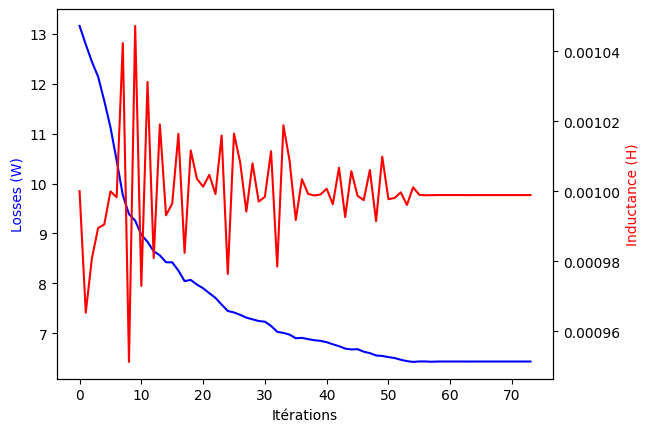

In [128]:
ax1 = plt.plot(LossList, color = 'b')   
plt.ylabel('Losses (W)', color = 'b')
plt.xlabel('Itérations')
ax2 = plt.gca().twinx()
ax2.plot(InductanceList, color = 'r')
plt.ylabel('Inductance (H)', color = 'r')
plt.show()

In [131]:
meshOptim = gen_mesh2(airgapList[-1])
Draw(1 * XiAir + 2 * XiCoil + 3 * XiCore, meshOptim, radius=0.02)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene